# Simple Tv Series multi-label Clasification Using ClassifierChain ######
___
EL objetivo es  poder identificar a qué géneros pertenece una serie tv por medio de lo escrito en su sinopsis


###### Librerias de manejo y exploracion de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###### Librerias para Text Mining

In [2]:
import string 
import re
from nltk.corpus import stopwords # para excluir palabras 
from nltk.stem.wordnet import WordNetLemmatizer # lematizar : para transformar las palabra a un estadod mjor
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.corpus import stopwords

#### Librarias y funciones para model training

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [4]:
datos = pd.read_csv('../datos/tablas_series_tv.csv',sep=";").drop('Unnamed: 0',axis=1)

## Exploración de Datos
***

In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
Titulo      4800 non-null object
Sinopsis    4162 non-null object
Genero      4800 non-null object
dtypes: object(3)
memory usage: 112.6+ KB


In [6]:
datos.head()

,Titulo,Sinopsis,Genero
0,#Cartel,#Cartel es una serie dramática de televisión d...,"Suspense,Judicial"
1,'Allo 'Allo,La vida es cualquier cosa menos simple para Re...,Comedia
2,(Des)encanto,(Des)encanto es una comedia de animación para ...,"Fantasía,Animación"
3,+ De 100 Mentiras,+ De 100 Mentiras narra la historia de un hack...,"Drama,Suspense"
4,10,NaN,Drama


Hay series que no cuentan con una sinopsis, por lo tanto se eliminan.

In [7]:
datos = datos.dropna().reset_index(drop=True)
datos.head()

,Titulo,Sinopsis,Genero
0,#Cartel,#Cartel es una serie dramática de televisión d...,"Suspense,Judicial"
1,'Allo 'Allo,La vida es cualquier cosa menos simple para Re...,Comedia
2,(Des)encanto,(Des)encanto es una comedia de animación para ...,"Fantasía,Animación"
3,+ De 100 Mentiras,+ De 100 Mentiras narra la historia de un hack...,"Drama,Suspense"
4,10 Razones para odiarte,"En el colegio Padua High, las hermanas Kat y B...",Comedia


###### Variable Género : construcción y análisis del target 
Se observa que después de romántico la frecuenca baja cerca a cero.

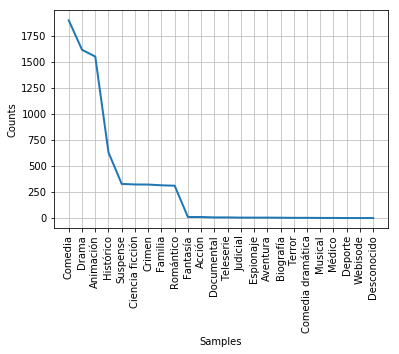

FreqDist({'Comedia': 1896, 'Drama': 1614, 'Animación': 1549, 'Histórico': 630, 'Suspense': 328, 'Ciencia ficción': 323, 'Crimen': 322, 'Familia': 315, 'Romántico': 311, 'Fantasía': 11, ...})

In [8]:
c = [i.split(',') for i in datos.Genero]
generos = [i for j in c for i in j]
frec_genro = FreqDist(generos)
frec_genro.plot()
frec_genro

Nos quedamos con los géneros de las series que tienen una presencia significativa.

In [9]:
Genro = np.array(['Comedia','Drama', 'Animación', 'Histórico','Suspense','Ciencia ficción','Crimen','Familia','Romántico'])

##### Construimos dummies género de las series de tv

Construcción de la tabla con ceros.

In [10]:
Genro_dummies = pd.DataFrame(np.zeros((datos.shape[0],len(Genro))),columns=Genro)
Genro_dummies.head()

,Comedia,Drama,Animación,Histórico,Suspense,Ciencia ficción,Crimen,Familia,Romántico
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Con el metodo str.find puedo encontrar la posición de una palabra dentro de un texto
- datos.Genero[0] # 'Suspense,Judicial'
- datos.Genero[0].find('Suspense') # 0; me da posición  de 'Suspense'
- En caso la posición se negativo, significa que la palabra no se encuentra

Se preguntará la posición para cada género en la variable datos['Genero'].<br>
Si la posición es mayor o igual a cero entonces se cambia a valor de 1, de lo contrario es cero

In [11]:
for i in Genro :
    Genro_dummies[i]= np.int0(datos.Genero.str.find(i)>=0)
Genro_dummies.head()

,Comedia,Drama,Animación,Histórico,Suspense,Ciencia ficción,Crimen,Familia,Romántico
0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0


Contamos cuantos casos están asignados a al menos un género y cuantos casos no(pertencío a un género sin presencia significativa)

In [12]:
filt_casos = Genro_dummies.apply(sum,axis=1)>0
sum(filt_casos==True),sum(filt_casos==False) #11 casos que deben pertencer a los genero sin presencia significativa

(4151, 11)

Solo salen 11 casos

In [13]:
datos_f = datos.loc[filt_casos,:]
Genro_dummies = Genro_dummies[filt_casos]

DataFrame final

In [14]:
datos_new = pd.concat([datos[filt_casos],Genro_dummies],axis=1)

In [15]:
datos_new.shape,datos.shape

((4151, 12), (4162, 3))

In [16]:
datos_new.head()

,Titulo,Sinopsis,Genero,Comedia,Drama,Animación,Histórico,Suspense,Ciencia ficción,Crimen,Familia,Romántico
0,#Cartel,#Cartel es una serie dramática de televisión d...,"Suspense,Judicial",0,0,0,0,1,0,0,0,0
1,'Allo 'Allo,La vida es cualquier cosa menos simple para Re...,Comedia,1,0,0,0,0,0,0,0,0
2,(Des)encanto,(Des)encanto es una comedia de animación para ...,"Fantasía,Animación",0,0,1,0,0,0,0,0,0
3,+ De 100 Mentiras,+ De 100 Mentiras narra la historia de un hack...,"Drama,Suspense",0,1,0,0,1,0,0,0,0
4,10 Razones para odiarte,"En el colegio Padua High, las hermanas Kat y B...",Comedia,1,0,0,0,0,0,0,0,0


Grafica de casos multi-etiqueta.

In [17]:
a = Genro_dummies.apply(lambda x : ','.join(x.astype(str)),axis=1)
b = pd.crosstab(a,True)
c = list(b.index.str.split(','))
d = [[bool(int(i)) for i in d] for d in c]

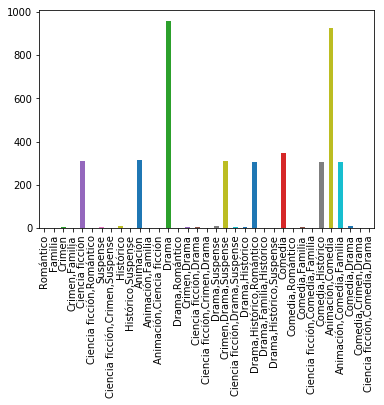

In [18]:
res_gnero = pd.Series(b.values.reshape(b.values.shape[0]),index=[','.join(np.unique(Genro[i])) for i in d])
res_gnero.plot.bar()

###### Sinopsis : limpieza, transformación y preparación de textos

In [19]:
stop = stopwords.words('spanish')

In [20]:
stop.extend(['comedia', 'crama', 'animación', 'histórico', 'suspense', 'crimen','siencia ficción',
       'familia', 'romántico'])
exclude = set(string.punctuation) 

In [21]:
# Lemmatizacion de las palabras 
lemma = WordNetLemmatizer() 
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    normalized2 = " ".join(list(set([i for i in normalized.split() if i not in stop])))
    return normalized2

Sin limpieza de texto

In [22]:
plt.figure(figsize=(200,200))
wordcloud = WordCloud(
            background_color ='white',
            min_font_size = 10,max_words=20).generate(' '.join(datos_f.Sinopsis))
plt.imshow(wordcloud)

Con limpieza de Texto

In [23]:
datos_new['Sinopsis']=[clean(i) for i in datos_new.Sinopsis]

In [24]:
plt.figure(figsize=(200,200))
wordcloud = WordCloud(
            background_color ='white',
            min_font_size = 5,max_words=100).generate(' '.join(datos_new.Sinopsis))
plt.imshow(wordcloud)

#### Preparación para training

In [25]:
# El metodo CountVectorizer de sklearn hace todo el preprocesamiento junto, stopwords, lowercase;tokenizacion usando regex
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words=stop, lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
X= vectorizer.fit_transform(datos_new.Sinopsis)

y = Genro_dummies


#### Training model

In [26]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=41)

In [27]:
classifier = ClassifierChain(DecisionTreeClassifier())
classifier.fit(Xtrain, ytrain)

ClassifierChain(classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
        order=None, require_dense=[True, True])

In [28]:
predictions = classifier.predict(Xtest)

In [29]:
Genro

array(['Comedia', 'Drama', 'Animación', 'Histórico', 'Suspense',
       'Ciencia ficción', 'Crimen', 'Familia', 'Romántico'], dtype='<U15')

In [30]:
print(classification_report(ytest,predictions,
                            target_names=Genro))

                 precision    recall  f1-score   support

        Comedia       0.98      0.98      0.98       622
          Drama       0.98      0.96      0.97       542
      Animación       0.98      1.00      0.99       510
      Histórico       0.97      0.98      0.97       214
       Suspense       0.93      0.93      0.93       120
Ciencia ficción       0.99      0.98      0.98        96
         Crimen       0.96      0.96      0.96       114
        Familia       0.96      1.00      0.98        95
      Romántico       0.95      1.00      0.98       106

    avg / total       0.97      0.98      0.98      2419

